# Final assignment 

This notebook develops the practice part of the final assignment. The writing part can be found [here](https://github.com/lucasmoschen/phd-bayesian-statistics/blob/main/notes/final_assignment/A2.pdf).

## Inferring population sizes - practice

Consider the problem of inferring the population sizes of major herbivores. In the first case, one is interested in estimating the number of impala (*Aepyceros melampus*) herds in the Kruger National Park, in northeastern South Africa. In an initial survey collected the following numbers of herds: $\boldsymbol{x}_{\text{impala}} = \{15, 20, 21, 23, 26\}$. Another scientific question is the number of individual waterbuck (*Kobus ellipsiprymnus*) in the same park. The observed numbers of waterbuck in separate sightings were $\boldsymbol{x}_{\text{waterbuck}} = \{53, 57, 66, 67, 72\}$ and may be regarded (for simplicity) as independent and identically distributed.

Impala           |  Waterbuck
:-------------------------:|:-------------------------:
![impala](../notes/final_assignment/figures/impala.jpeg)|![waterbuck](../notes/final_assignment/figures/waterbuck.jpeg)
Two antelope species whose population sizes we want to estimate.

For each data set, sketch the marginal posterior distributions $p_1(N \mid \boldsymbol{x})$, $p_2(N \mid \boldsymbol{x})$ and $p_3(N \mid \boldsymbol{x})$. Moreover, under each posterior,  provide (i) the Bayes estimator under quadratic loss and under the relative quadratic loss and (ii) a 95\% credibility interval for $N$.

Discuss the differences and similarities between these distributions and estimates: do the prior modelling choices substantially impact the final inferences? If so, how?

In [15]:
import numpy as np 
import pystan as ps
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az

from scipy.special import beta, comb

### Raftery approach

We define the model for the Raftery approach. 

In [6]:
model_raftery = """
data{
    int<lower = 0> n;
    int x_obs[n];
    
    real<lower = 0> a;
    real<lower = 0> b;
    real<lower = 0> alpha;
    real<lower = 0> beta;
}
transformed data{
    real S = sum(x_obs);
}
parameters{ 
    real<lower = 0, upper = 1> theta;
    real<lower = max(x_obs)> N; 
}
transformed parameters{
    real lPbar = 0.0;
    for(j in 1:n) lPbar += lchoose(N, x_obs[j]);
}
model{
    target += lPbar + lgamma(alpha + N) - lgamma(N+1);
    target += (a+S-1-N)*log(theta) + (b+n*N -S - 1)*log(1-theta); 
    target += -(alpha+N)*log(beta + 1/theta);
}
generated quantities{
    real MME1 = 1/N;
    real MME2 = 1/N^2;
}
"""

In [7]:
sm_raft = ps.StanModel(model_code = model_raftery)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_696db612137e19e852243acc471e9eb6 NOW.


### Raftery + uniformative

The model is the same as previous, but with $\alpha = \beta = 0$ and $a = b = 1$. 

### Geometric independent approach

We define the model for the Geometric and independent approach. 

In [195]:
model_geom = """
functions {
  real geometric_real_lpdf(real N, real p){
      return N*log(1 - p) + log(p);
  }
  real binomial_real_lpmf(int[] x, real n, real p){
      real lpbar = 0.0;
      for(j in 1:size(x)) lpbar += lchoose(n, x[j]);
      return lpbar + sum(x)*log(p) + (size(x)*n - sum(x))*log(1 - p);
  }
}
data{
    int<lower = 0> n;
    int x_obs[n];
    
    real<lower = 0> alpha1;
    real<lower = 0> beta1;
    real<lower = 0> alpha2;
    real<lower = 0> beta2;
}
transformed data{
    real S = sum(x_obs);
}
parameters{ 
    real<lower = max(x_obs)> N;
    real<lower = 0, upper = 1> theta;
    real<lower = 0, upper = 1> nu;
}
model{
    theta ~ beta(alpha2, beta2);
    nu ~ beta(alpha1, beta1);
    
    N ~ geometric_real(nu);
    
    x_obs ~ binomial_real(N, theta);
}
generated quantities{
    real MME1 = 1/N;
    real MME2 = 1/N^2;
}
"""

In [196]:
sm_geomid = ps.StanModel(model_code=model_geom)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e691702e0401c953a0af1c320f1d8c1 NOW.


### Geometric correlated approach 

We define the model for the Geometric and correlatedreallen approach. 

## Experimenting after defining the models 

Now we use the data to test the models 

### Data

In [10]:
impala = np.array([15,20,21,23,26])
waterbuck = np.array([53,57,66,67,72])

### Impala data

First we use the impala data to deal with the problems. 

In [82]:
raft_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'a': a = 1, 
    'b': 1,
    'alpha': 1,
    'beta': 0.5,
}

fit_raftery = sm_raft.sampling(data=raft_data, iter=50000, chains=5,
                               control=dict(adapt_delta=0.95))

print(fit_raftery)

In [95]:
uninf_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'a': 1, 
    'b': 1,
    'alpha': 0,
    'beta': 0,
}

fit_uninf = sm_raft.sampling(data=uninf_data, iter=50000, chains=5,
                             control=dict(adapt_delta=0.95))

print(fit_uninf)

In [197]:
geom_id_data = {
    "x_obs": impala,
    "n": impala.shape[0],
    'alpha1': 2, 
    'alpha2': 1,
    'beta1': 2,
    'beta2': 1,
}

fit_geomid = sm_geomid.sampling(data=geom_id_data, iter=4000, chains=5,
                                control=dict(adapt_delta=0.99))

print(fit_geomid)

Inference for Stan model: anon_model_9e691702e0401c953a0af1c320f1d8c1.
5 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N      47.65    0.54  24.22  27.88  33.76   40.6  52.27 113.19   1982    1.0
theta    0.5  3.3e-3   0.15   0.18    0.4   0.51   0.62   0.77   2164    1.0
nu      0.07  7.1e-4   0.04   0.01   0.04   0.06   0.09   0.16   3190    1.0
MME1    0.02  1.6e-4 7.2e-3 8.8e-3   0.02   0.02   0.03   0.04   2118    1.0
MME2  6.3e-4  7.2e-6 3.3e-4 7.8e-5 3.7e-4 6.1e-4 8.8e-4 1.3e-3   2135    1.0
lp__  -24.98    0.03   1.31 -28.37 -25.57 -24.65 -24.01 -23.48   2387    1.0

Samples were drawn using NUTS at Sun Jun  6 17:08:23 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


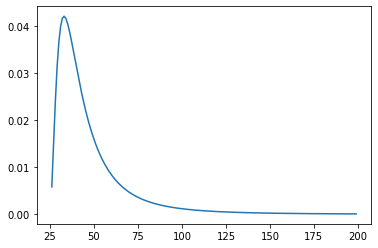

In [202]:
S = sum(impala)
n = len(impala)
xmax = max(impala)

def p1_geom_unnorm(N, x_obs): 
    
    result = np.prod([comb(N,i) for i in x_obs])
    result *= beta(geom_id_data["alpha1"] + 1, N + geom_id_data["beta1"])
    result *= beta(S+geom_id_data["alpha2"], n*N - S + geom_id_data["beta2"])
    return result

constant = 0 
N = 26
eps = 1
while eps > 1e-16: #np.finfo(np.float64).eps: 
    eps = p1_geom_unnorm(N, impala)
    constant += eps
    N += 1
    
def p1_geom(N, x_obs): 
    
    return p1_geom_unnorm(N, x_obs)/constant

N_values = list(range(26,200))
plt.plot(N_values, [p1_geom(N,impala) for N in N_values])

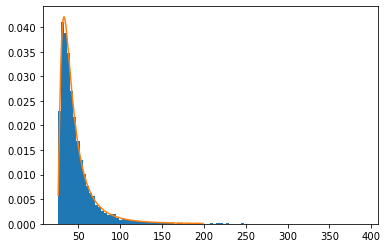

In [209]:
fig, ax = plt.subplots()
ax.hist(fit_geomid.extract()["N"], bins= 100, density = True)
ax.plot(N_values, [p1_geom(N,impala) for N in N_values])

# PyMC3 testes

In [167]:
with pm.Model() as model: 
    
    theta = pm.Beta('theta', alpha=geom_id_data["alpha2"], beta=geom_id_data["beta2"])
    nu = pm.Beta('nu', alpha=geom_id_data["alpha1"], beta=geom_id_data["beta1"])
    
    N = pm.Bound(pm.Geometric, lower = max(impala))("N", p = nu)
    
    x = pm.Binomial("x", n=N, p=theta, observed=impala)
    
    prior_checks = pm.sample_prior_predictive(samples=1000)
    
    trace = pm.sample(draws = 8000, tune=8000,
                      nuts = {"target_accept": 0.96})
    
    display(az.summary(trace))

INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:CompoundStep
INFO:pymc3:>NUTS: [nu, theta]
INFO:pymc3:>Metropolis: [N]


INFO:pymc3:Sampling 2 chains for 8_000 tune and 8_000 draw iterations (16_000 + 16_000 draws total) took 29 seconds.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
N,69.198,45.978,26.000,162.000,10.431,7.490,19.0,19.0,38.0,49.0,1.10
theta,0.408,0.187,0.090,0.711,0.030,0.021,39.0,39.0,39.0,61.0,1.06
nu,0.027,0.018,0.002,0.059,0.001,0.001,258.0,258.0,207.0,1883.0,1.01


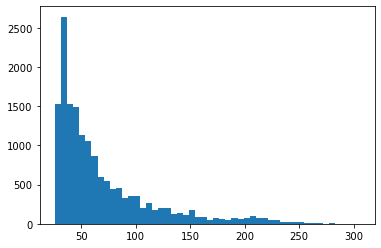

In [168]:
plt.hist(trace["N"], bins = 50)
plt.show()

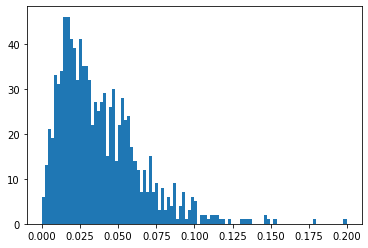

In [174]:
plt.hist(prior_checks['nu'], bins = 100)
plt.show()